In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import random
from imdbDataSet import *
import sklearn.metrics
import sklearn.ensemble
import sklearn.model_selection
import sklearn.tree

In [2]:
# IG
def informationGain(category_vector, feature):
    category_set = set(category_vector)
    
    # calculate entropy
    HC = 0
    for c in category_set:
        PC = category_vector.count(c) / len(category_vector) # P(C=c)
        HC += - PC * np.log2(PC)
    #print("Entropy:", HC)
    
    # calculate IG(C, X)
    feature_set = set(feature)
    HC_feature = 0
    for value in feature_set:
        # p_feature --> P(X=x)
        P_feature = feature.count(value) / len(feature) # count occurences of value
        indices = [i for i in range(len(feature)) if feature[i] == value] # rows that have X=x
        category_of_feature = [category_vector[i] for i in indices] # category of rows listed in indices above
        for c in category_set:
            # PC_feature --> P(C=c|X=x)
            PC_feature = category_of_feature.count(c) / len(category_of_feature) # given X=x, count C
            if PC_feature != 0:
                # - P(X=x) * P(C=c|X=x) * log2(P(C=c|X=x))
                temp_H = - P_feature * PC_feature * np.log2(PC_feature)
                # sum for all values of C (class) and X (values of specific feature)
                HC_feature += temp_H
    IG = HC - HC_feature
    return IG

In [3]:
def amountOfSay(totalError):
    a = 0.5 * np.log((1 - totalError) / totalError)
    return a

def plotAmountOfSay(totalError, a):
    # plot the performance curve
    plt.xlabel("Error rate")
    plt.ylabel("Alpha")
    # evenly sampled error rate at 0.02 intervals
    err_rate = np.arange(0.02, 1., 0.02)
    plt.plot(err_rate, 0.5*np.log((1 - err_rate)/err_rate), '#004883')
    # plot our α
    plt.plot([totalError], [a], 'go', label="α = " + str(a))
    x_0_dotted = np.arange(-2, a+0.05, 0.05)
    y_0_dotted = np.arange(0., totalError+0.05, 0.05) if a < 2 else np.arange(0., totalError, 0.05)
    plt.plot(np.zeros(len(x_0_dotted)) + totalError, x_0_dotted, 'g--', linewidth=0.8)
    plt.plot(y_0_dotted, np.zeros(len(y_0_dotted)) + a, 'g--', linewidth=0.8)
    
    plt.legend()
    plt.show()

In [79]:
class Adaboost:
    def __init__(self, n_estimators=100):
        self.n_estimators = n_estimators
        self.chosen_stumps = [] # all the hypothesis
        self.alphas = [] # amounts of say for each stump

    def fit(self, X, y):
        n = X.shape[0] # number of samples
        f = X.shape[1] # number of features

        w = [1/n for _ in range(n)]

        for m in range(self.n_estimators):
            stump = sklearn.tree.DecisionTreeClassifier(max_depth=1)
            stump.fit(X, y, sample_weight=w)
            self.chosen_stumps.append(stump)

            error = 1 - stump.score(X, y, w)
            #print("Error:", error)

            predictions = stump.predict(X)

            for i in range(n):
                if (predictions[i] == y[i]):
                    w[i] = w[i] * (error/(1 - error))
            
            w = [weight/sum(w) for weight in w]

            a = amountOfSay(error)
            self.alphas.append(a)
            #print("Amount of say:", a)
            
    def predict(self, X):
        stump_predictions = np.zeros((self.n_estimators, X.shape[0]))
        for s in range(len(self.chosen_stumps)):
            stump = self.chosen_stumps[s]
            prediction = stump.predict(X)
            stump_predictions[s] = prediction
            
        final_preds = []
        for i in range(len(stump_predictions.T)):
            positives = []
            negatives = []
            for j in range(len(stump_predictions)):
                if (stump_predictions.T[i][j] == 0):
                    negatives.append(self.alphas[j])
                else:
                    positives.append(self.alphas[j])
            if (sum(positives) > sum(negatives)):
                final_preds.append(1)
            else:
                final_preds.append(0)

        return final_preds
    
    def predict_proba(self, X):
        probas = []
        for x in X:
            positives = []
            negatives = []
            x_reshaped = x.reshape(1, -1)
            for s in range(len(self.chosen_stumps)):
                proba = self.chosen_stumps[s].predict_proba(x_reshaped)
                if (proba[0][0] > proba[0][1]):
                    negatives.append(proba[0][0])
                else:
                    positives.append(proba[0][1])

            if (sum(positives)/len(positives) > sum(negatives)/len(negatives)):
                probas.append(sum(positives)/len(positives))
            else:
                probas.append(sum(negatives)/len(negatives))
            
        return probas


In [80]:
imdb = IMDB()

def runTest(N=250, M=1000, N_ESTIMATORS=50, TRAIN=1000, TESTS=1000):
    res = imdb.getTrainingData(1, 2, 3, N, M, 2000)

    # get feature vector
    features = imdb.getFeatureVector(N, M)

    # get values of each feature for n movie reviews
    n = TRAIN
    X_train = np.zeros((n, len(features)))
    y_train = list()
    X_test = np.zeros((n, len(features)))
    y_test = list()
    # for the first n reviews
    for i in range(n):
        x_i = imdb.getXtrain(i)
        xt_i = imdb.getXtest(i)
        y_train.append(imdb.getYtrain(i))
        y_test.append(imdb.getYtest(i))
        # for word index in x_train
        for wi in x_i:
            if wi == 2:
                continue
            elif (wi in features):
                j = features.index(wi)
                X_train[i][j] = 1
        for wi in xt_i:
            if wi == 2:
                continue
            elif (wi in features):
                j = features.index(wi)
                X_test[i][j] = 1

    X_test = X_test[:TESTS]
    y_test = y_test[:TESTS]

    ab = Adaboost(N_ESTIMATORS)
    ab.fit(X_train, y_train)

    y_pred_train = ab.predict(X_train[:TESTS])
    y_pred_test = ab.predict(X_test)

    y_proba_test = ab.predict_proba(X_test)

    # accuracy train, test
    accuracy_train = sklearn.metrics.accuracy_score(y_true=y_train[:TESTS], y_pred=y_pred_train)
    accuracy_test = sklearn.metrics.accuracy_score(y_true=y_test, y_pred=y_pred_test)
    precision, recall, _ = sklearn.metrics.precision_recall_curve(y_true=y_test, probas_pred=y_proba_test)

    disp = sklearn.metrics.PrecisionRecallDisplay(precision, recall)
    disp.plot()

    print("Accuracy Train:", accuracy_train)
    print("Accuracy Test:", accuracy_test)
    print("")

    return accuracy_train, accuracy_test

Accuracy Train: 1.0
Accuracy Test: 0.69

Accuracy Train: 0.945
Accuracy Test: 0.655

Accuracy Train: 0.8933333333333333
Accuracy Test: 0.72

Accuracy Train: 0.89
Accuracy Test: 0.6975

Accuracy Train: 0.852
Accuracy Test: 0.704

Accuracy Train: 0.8516666666666667
Accuracy Test: 0.7183333333333334

Accuracy Train: 0.8214285714285714
Accuracy Test: 0.7257142857142858

Accuracy Train: 0.81125
Accuracy Test: 0.74375

Accuracy Train: 0.8122222222222222
Accuracy Test: 0.75

Accuracy Train: 0.809
Accuracy Test: 0.747



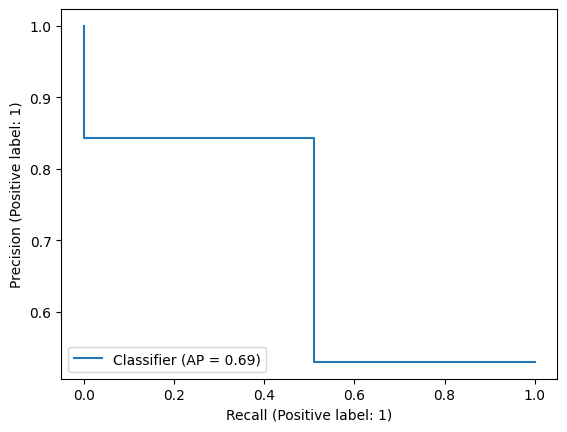

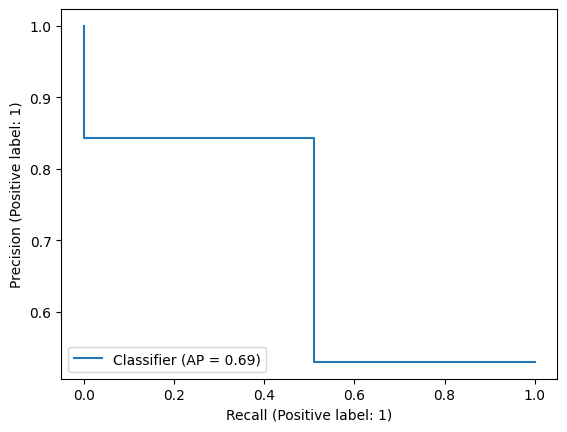

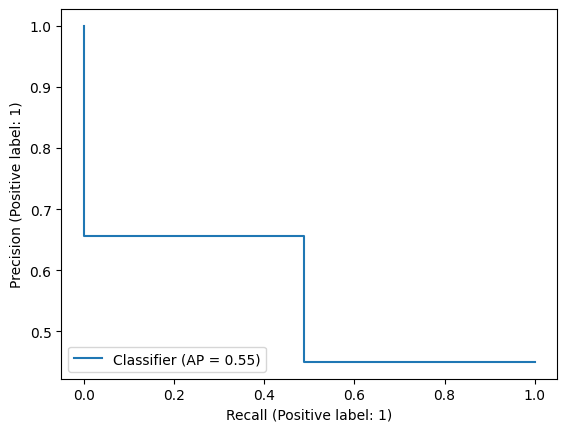

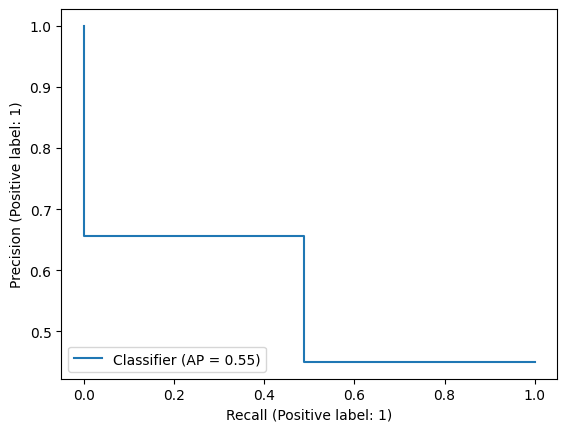

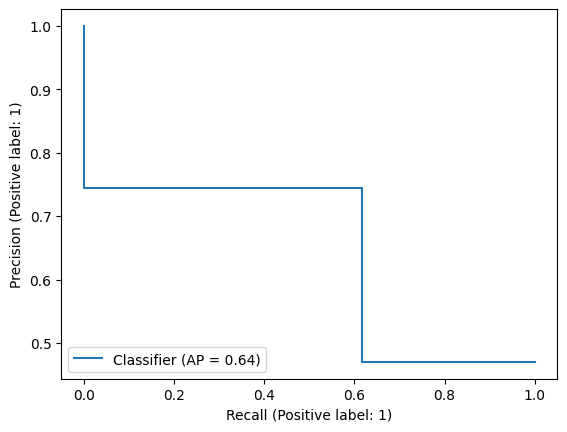

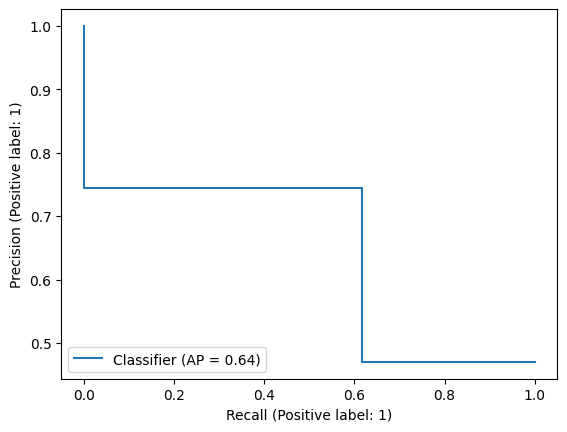

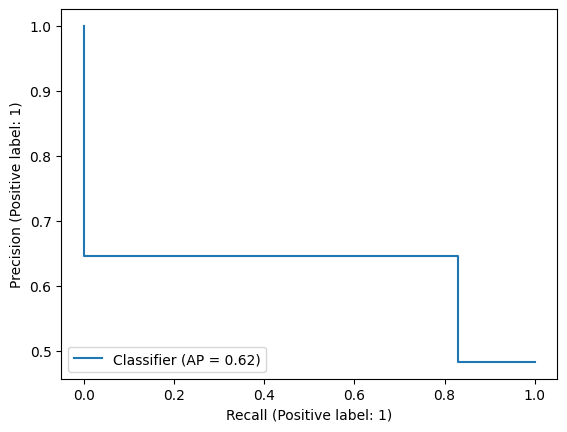

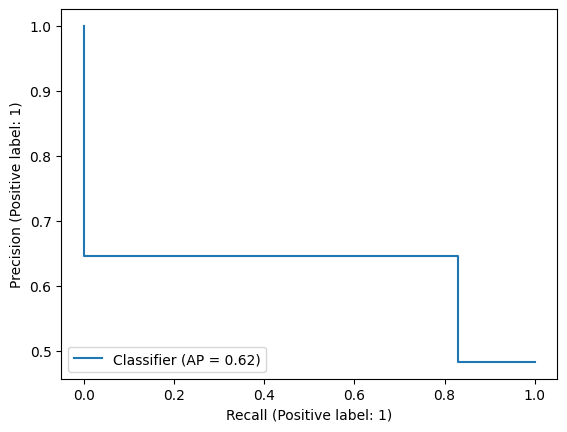

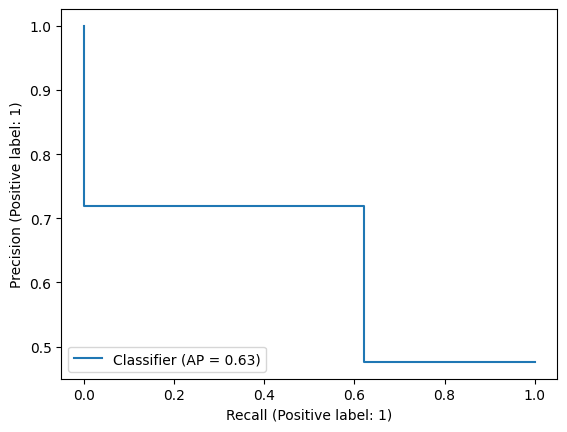

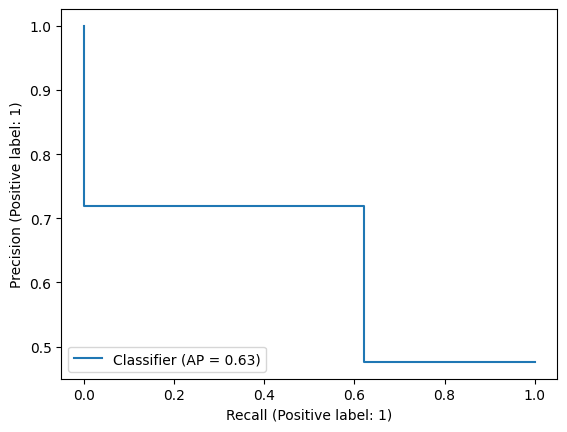

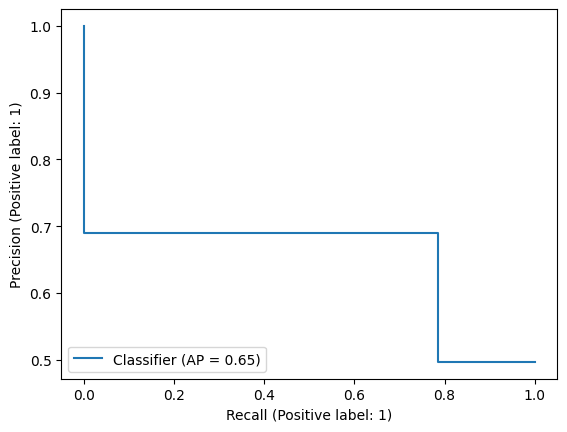

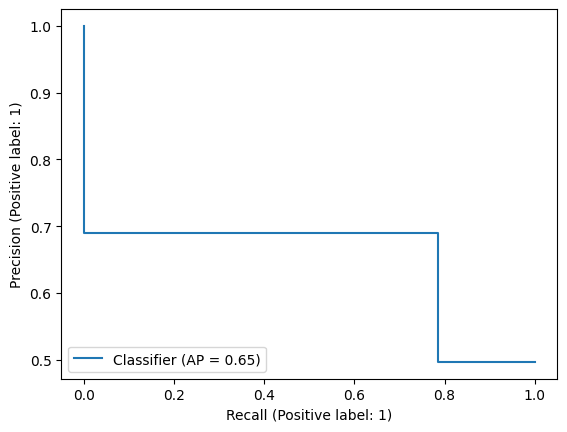

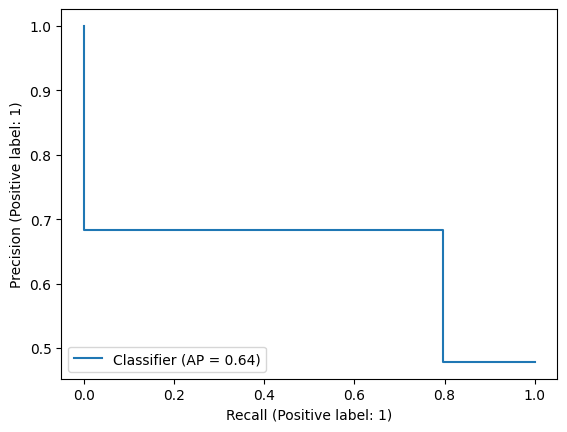

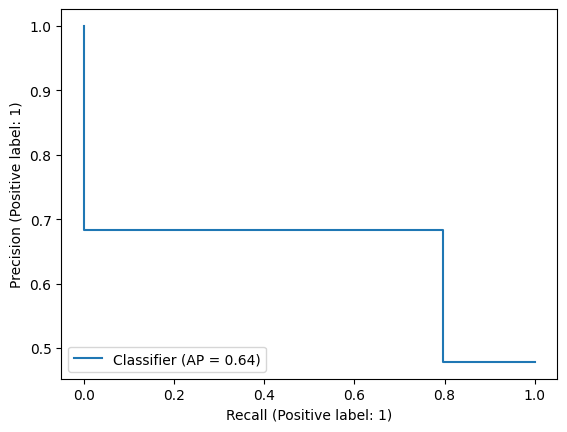

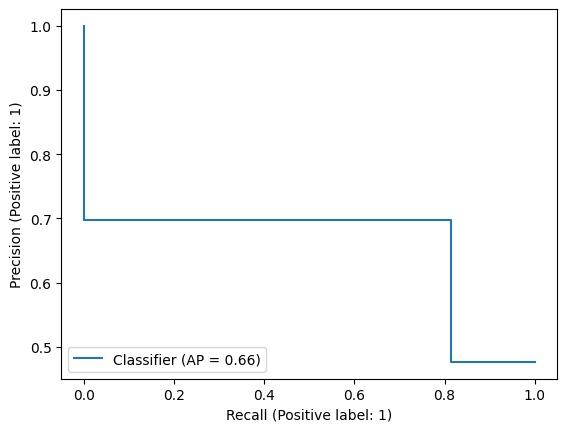

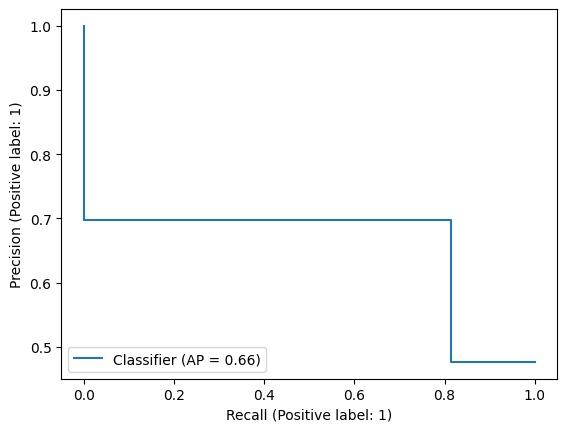

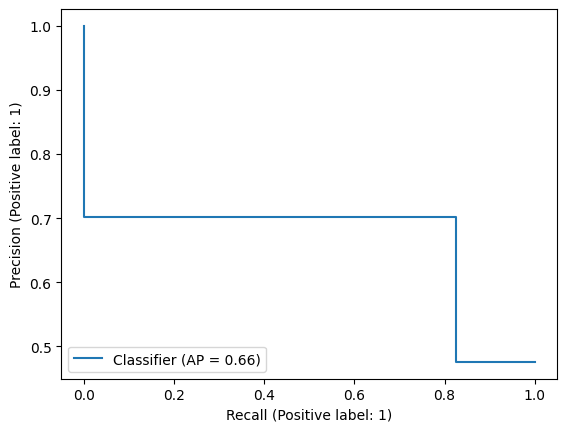

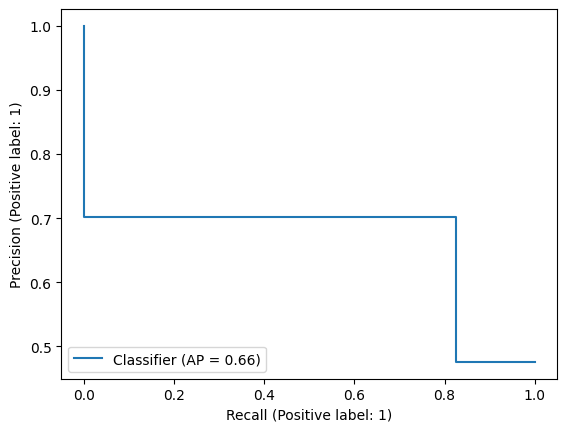

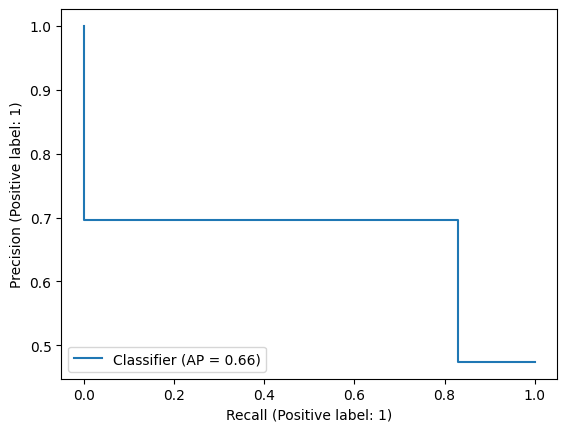

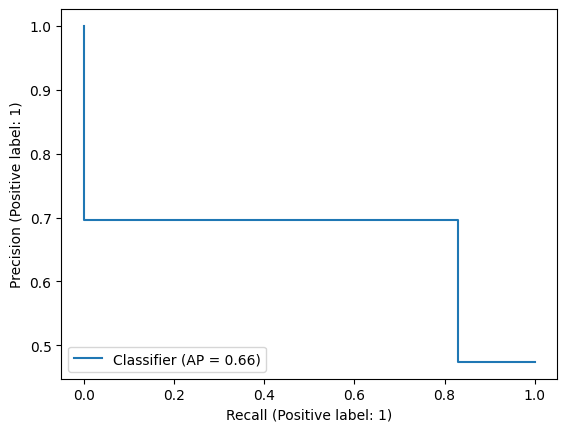

In [81]:
x = []
accuracy_score_train = []
accuracy_score_test = []

for i in range(10):
    x.append(100*(i+1))
    ac_tr, ac_test = runTest(250, 1000, 100, 100*(i+1), 1000)
    accuracy_score_train.append(ac_tr)
    accuracy_score_test.append(ac_test)


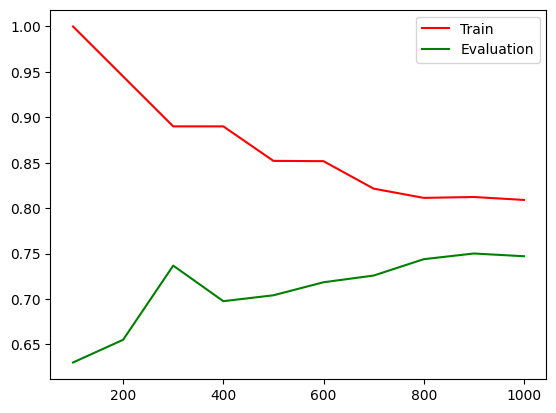

In [74]:
# plot accuracy train, test
plt.plot(x, accuracy_score_train, 'red', label="Train")
plt.plot(x, accuracy_score_test, 'green', label="Evaluation")

plt.legend()
plt.show()